In [9]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os
import string
import time

In [10]:
# Function to evaluate the entropy of a vector
# INPUTS
# - v: vector that contains in each cell the value of a byte (so from 0 to 255)
# - num: number of cells of the vector we want to consider in the analysis (from the first element)
# OUTPUT: entropy value
def entropy(v, num, offset):
    freq = np.zeros(offset)
    for i in range(num):
        freq[int(v[i])]=freq[int(v[i])]+1
    h = 0
    for i in range(offset):
        if freq[i]>0:
            h = h + (freq[i]/num) * np.log2(freq[i]/num)
    h = -h
    return h

# Function to evaluate the entropy of a file as a function of the header lenght
# INPUTS
# - file: the file we want to anlyze (formats as an integer vector)
# - Bytes: total number of bytes we want to consider in the analysis
# OUTPUT: vector that contains the entropy values as a function of the header lenght analyzed

def entropy_analysis(file, Bytes, offset):
    h_vector = np.zeros(int(Bytes/8)+1)
    for i in range(int(Bytes/8)+1):
        h_vector[i] = entropy(file, 8*i, offset)
    return h_vector

# Function to evaluate the Area (DDA approach) between two files 
# INPUTS
# - h_1,h_2: vectors obtained with entropy_analysis function
# OUTPUT: value of the area
def diff_area(h_1,h_2):
    area = 0
    length = min(len(h_1),len(h_2))
    diff_vec = np.zeros(length)
    for i in range(length):
        diff_vec[i]=abs(h_1[i]-h_2[i])
    sum = 0
    for i in range(2,length-2):
        sum = sum+2*diff_vec[i]
    area = (8/2)*(diff_vec[1]+diff_vec[len(h_1)-1]+sum)
    return area

# Function to transform the file of the dataset in a vector ready to be analyzed
# INPUTS
# - file: the file from the dataset we want to analyze
# - size: the size of the file we want to cut
# OUTPUT: file vector
def file_to_vector(file, start, offset):
    vec = np.zeros(offset)
    for i in range(offset):
        vec[i] = int.from_bytes(bytes(file[start + i], 'latin-1'), byteorder="big")
    return vec

# Return a vector containing ones, if for different header lengths correctly classify a file, and 0.0 otherwise. y is the correct result (True or False),
def accuracies(threshold, areas, offset, y):
    accuracies = np.zeros([int(offset/8),1], dtype=float)
    errors = np.zeros([int(offset/8),1], dtype=float)
    for i in range(len(areas)):
        # True negatives
        if y==False and areas[i] > threshold:
            accuracies[i] = 1.0
        # True positives
        if y==True and areas[i] <= threshold:
            accuracies[i] = 1.0
        # False negatives
        if y==False and areas[i] <= threshold:
            errors[i] = 1.0
        # False positives
        if y==True and areas[i] > threshold:
            errors[i] = 1.0
    return accuracies, errors

#analyze the differential area of file_vector from the byte at position start to the byte at position end
def trapezoidal_rule(ideal_file, file_vector, offset):
    area = np.zeros(int(offset/8))
    # Iterate over the different header lenghts of the file
    for i in range(8, offset + 1, 8):
        h_ideal = entropy_analysis(ideal_file, i, offset)
        h = entropy_analysis(file_vector, i, offset)
        area[int(i/8)-1] = diff_area(h_ideal,h)
    return area

We start to create encrypted by ransowmare files that contains in the first 256 bytes repetitions of the first 8 bytes of the original files. Mainly, we copy each files encrypted by ransomware and we change the first 256 bytes using repetition.

In [1]:
# Obtains all paths to analyze from a .txt files
f = open('./paths/path_ransomwares.txt', 'r')
paths = f.readlines()
files=os.listdir(paths[2][:-1])
f.close()
bytes_range=8

#Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    folders = paths[j].split('/')
    new_path = './NapierOneDataset/EXTRA/' + folders[3][:-1] + '-repeat-ciphertext'
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    print("Start creating new files with repetitions in the directory", new_path)
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        org_file = open(full_path, "rb")
        new_file = open(new_path + "/" + object, "wb")
        # first 8 bytes are road from the original file
        first_bytes = org_file.read(bytes_range)
        # first 8 bytes of the original file are wrote in a redundant way in the new file until 256 bytes
        for i in range(0,int(256/bytes_range)):
            new_file.seek(int(i*bytes_range))
            new_file.write(first_bytes)
        # next to the 256 bytes, the bytes of the original file are the same of the new file
        new_file.seek(256)
        org_file.seek(256)
        remain_size=os.path.getsize(full_path)-256
        next_bytes = org_file.read(remain_size)
        new_file.write(next_bytes)
        org_file.close()
        new_file.close()

Start creating new files with repetitions in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start creating new files with repetitions in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start creating new files with repetitions in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start creating new files with repetitions in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start creating new files with repetitions in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start creating new files with repetitions in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start creating new files with repetitions in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start creating new files with repetitions in the directory ./NapierOneDataset/EXTRA/Wannacry-tiny-repeat-ciphertext
Star

Now we create files with the first 256 bytes with low entropy bytes. These files are the copy of the ones encrypted by the ransomware with just the first 256 bytes different.

In [2]:
# Obtains all paths to analyze from a .txt files
f = open('./paths/path_ransomwares.txt', 'r')
paths = f.readlines()
files=os.listdir(paths[2][:-1])
f.close()
low_entropy_bytes= ''.join((['a' for i in range(0,256)]))
low_entropy_bytes = low_entropy_bytes.encode('latin-1')
bytes_range=len(low_entropy_bytes)

#Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    folders = paths[j].split('/')
    new_path = './NapierOneDataset/EXTRA/' + folders[3][:-1] + '-low-entropy-bytes'
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    print("Start creating new files with low entropy bytes at the beginning in the directory", new_path)
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        org_file = open(full_path, "rb")
        new_file = open(new_path + "/" + object, "wb")
        new_file.write(low_entropy_bytes)
        # next to the 256 bytes, the bytes of the original file are the same of the new file
        new_file.seek(256)
        org_file.seek(256)
        remain_size=os.path.getsize(full_path)-256
        next_bytes = org_file.read(remain_size)
        new_file.write(next_bytes)
        org_file.close()
        new_file.close()

Start creating new files with low entropy bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-bytes
Start creating new files with low entropy bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-low-entropy-bytes
Start creating new files with low entropy bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-low-entropy-bytes
Start creating new files with low entropy bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-low-entropy-bytes
Start creating new files with low entropy bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-low-entropy-bytes
Start creating new files with low entropy bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-low-entropy-bytes
Start creating new files with low entropy bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANS

Now we create files with the first 256 bytes of sequences and/or common worlds. These files are the copy of the ones encrypted by the ransomware with just the first 256 bytes different.

In [5]:
# Obtains all paths to analyze from a .txt files
f = open('./paths/path_ransomwares.txt', 'r')
paths = f.readlines()
files=os.listdir(paths[2][:-1])
f.close()

# build the sequences
count_sequence= ''.join(([str(i) for i in range(0,22)]))
abc_sequence=string.ascii_lowercase
ABC_sequence=string.ascii_uppercase
common_worlds_sequence = " the of to and a in is it you that he was for "
zero_sequence = ''.join(([str(0) for i in range(0,32)]))
total_sequence = abc_sequence + common_worlds_sequence + count_sequence + zero_sequence +  abc_sequence + count_sequence + zero_sequence + ABC_sequence
total_sequence = total_sequence.encode('latin-1')
bytes_range=len(total_sequence)

#Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    folders = paths[j].split('/')
    new_path = './NapierOneDataset/EXTRA/' + folders[3][:-1] + '-common-sequences'
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    print("Start creating new files with common sequences bytes at the beginning in the directory", new_path)
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        org_file = open(full_path, "rb")
        new_file = open(new_path + "/" + object, "wb")
        new_file.write(total_sequence)
        # next to the 256 bytes, the bytes of the original file are the same of the new file
        new_file.seek(256)
        org_file.seek(256)
        remain_size=os.path.getsize(full_path)-256
        next_bytes = org_file.read(remain_size)
        new_file.write(next_bytes)
        org_file.close()
        new_file.close()

Start creating new files with common sequences bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-common-sequences
Start creating new files with common sequences bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-common-sequences
Start creating new files with common sequences bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-common-sequences
Start creating new files with common sequences bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-common-sequences
Start creating new files with common sequences bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-common-sequences
Start creating new files with common sequences bytes at the beginning in the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-common-sequences
Start creating new files with common sequences bytes at the beginning in the directory 

Now we perform the Differential Area Analysis of just the modified files encrypted by ransomware

In [7]:
offset = 256

ideal_file = np.zeros(offset)
for i in range(len(ideal_file)):
    ideal_file[i]=randint(0,offset-1)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('./paths/path_original_and_modified_files.txt', 'r')
paths = f.readlines()
thresholds = np.arange(8,80,2)
f.close()

acc = np.zeros([len(thresholds), len(paths), int(offset/8), 1], dtype = float)
true_positives = np.zeros([len(thresholds), len(paths), int(offset/8), 1], dtype = float)
true_negatives = np.zeros([len(thresholds), len(paths), int(offset/8), 1], dtype = float)
false_positives = np.zeros([len(thresholds), len(paths), int(offset/8), 1], dtype = float)
false_negatives = np.zeros([len(thresholds), len(paths), int(offset/8), 1], dtype = float)

In [11]:
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    files_analyzed = 0
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) >= offset:
            file_vector = file_to_vector(file, 0, offset)
            area = trapezoidal_rule(ideal_file, file_vector, offset)
            # Iterate over different threshold values
            for i in range(len(thresholds)):
                if paths[j][19:24] == "EXTRA":
                    # acc[i][j] is a vector of offset/8 values, each value represent the (TP + TN) for the differents header lengths of all the files in paths[j][:-1]
                    results = accuracies(thresholds[i], area, offset, True)
                    acc[i][j] = np.add(acc[i][j], results[0], dtype=float)
                    true_positives[i][j] = np.add(true_positives[i][j], results[0], dtype=float)
                    false_positives[i][j] = np.add(false_positives[i][j], results[1], dtype=float)
                else:
                    results = accuracies(thresholds[i], area, offset, False)
                    acc[i][j] = np.add(acc[i][j], results[0], dtype=float)
                    true_negatives[i][j] = np.add(true_negatives[i][j], results[0], dtype=float)
                    false_negatives[i][j] = np.add(false_negatives[i][j], results[1], dtype=float)
            files_analyzed += 1
    # acc[i][j] is a vector of 33 values, each value represent the accuracies for the differents header lengths of all the files in paths[j][:-1]
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    acc[i][j] = np.multiply(np.true_divide(acc[i][j], float(files_analyzed)), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes and %s seconds ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1))

Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-bytes
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-low-entropy-bytes
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-low-entropy-bytes
Start analysizng the dir

In [12]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code
acc_reshaped = acc.reshape(np.shape(acc)[0]*np.shape(acc)[1],np.shape(acc)[2])
np.save("./accuracies/accuracies_standard_analysis_org_and_mod_files.npy", acc_reshaped, fix_imports=False)

true_negatives_reshaped = true_negatives.reshape(np.shape(true_negatives)[0]*np.shape(true_negatives)[1],np.shape(true_negatives)[2])
np.save("./accuracies/true_negatives_standard_analysis_org_and_mod_files.npy", true_negatives_reshaped, fix_imports=False)

true_positives_reshaped = true_positives.reshape(np.shape(true_positives)[0]*np.shape(true_positives)[1],np.shape(true_positives)[2])
np.save("./accuracies/true_positives_standard_analysis_org_and_mod_files.npy", true_positives_reshaped, fix_imports=False)

false_negatives_reshaped = false_negatives.reshape(np.shape(false_negatives)[0]*np.shape(false_negatives)[1],np.shape(false_negatives)[2])
np.save("./accuracies/false_negatives_standard_analysis_org_and_mod_filess.npy", false_negatives_reshaped, fix_imports=False)

false_positives_reshaped = false_positives.reshape(np.shape(false_positives)[0]*np.shape(false_positives)[1],np.shape(false_positives)[2])
np.save("./accuracies/false_positives_standard_analysis_org_and_mod_files.npy", false_positives_reshaped, fix_imports=False)

In [13]:
# deserialize the tensor from the file .npy
acc_des=np.load('./accuracies/accuracies_standard_analysis_org_and_mod_files.npy')
acc_des = acc_des.reshape(len(thresholds), len(paths), int(offset/8))

TN_des=np.load('./accuracies/true_negatives_standard_analysis_org_and_mod_files.npy')
TN_des = TN_des.reshape(len(thresholds), len(paths), int(offset/8))

TP_des=np.load('./accuracies/true_positives_standard_analysis_org_and_mod_files.npy')
TP_des = TP_des.reshape(len(thresholds), len(paths), int(offset/8))

FN_des=np.load('./accuracies/false_negatives_standard_analysis_org_and_mod_filess.npy')
FN_des = FN_des.reshape(len(thresholds), len(paths), int(offset/8))

FP_des=np.load('./accuracies/false_positives_standard_analysis_org_and_mod_files.npy')
FP_des = FP_des.reshape(len(thresholds), len(paths), int(offset/8))

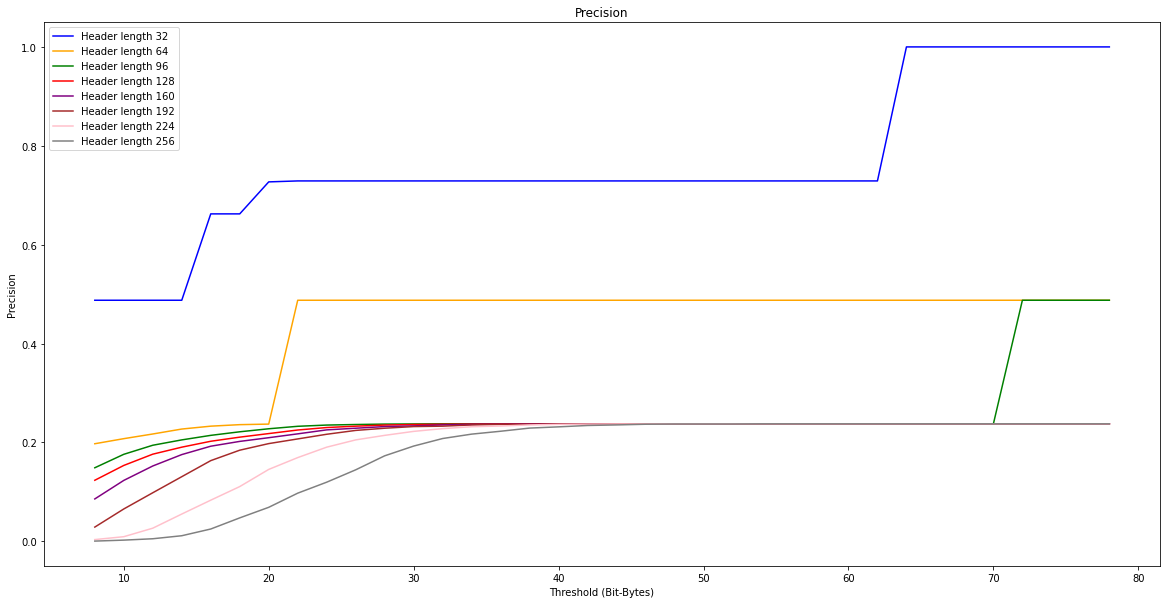

In [18]:
#Precision = TP/TP+FP

# Get for each threshold and header length the precision
hl_thresh= np.zeros([int(offset/8),len(thresholds)])
for i in range(int(offset/8)):
    for j in range(len(thresholds)):
        sumTP=0
        sumFP=0
        for k in range(len(paths)):
            sumTP=sumTP+TP_des[j][k][i]
            sumFP=sumFP+FP_des[j][k][i]
        if ((sumTP+sumFP))>0:
            hl_thresh[i][j] = sumTP/(sumTP+sumFP)

# Plot of the precision obtained using different threshold and different header lengths
plt.figure(figsize=(20,10))
plt.title("Precision")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("Precision")
plt.plot(thresholds, hl_thresh[3], color="blue", label="Header length 32")
plt.plot(thresholds, hl_thresh[7], color="orange", label="Header length 64")
plt.plot(thresholds, hl_thresh[11], color="green", label="Header length 96")
plt.plot(thresholds, hl_thresh[15], color="red", label="Header length 128")
plt.plot(thresholds, hl_thresh[19], color="purple", label="Header length 160")
plt.plot(thresholds, hl_thresh[23], color="brown", label="Header length 192")
plt.plot(thresholds, hl_thresh[27], color="pink", label="Header length 224")
plt.plot(thresholds, hl_thresh[31], color="grey", label="Header length 256")
plt.legend()
plt.show()

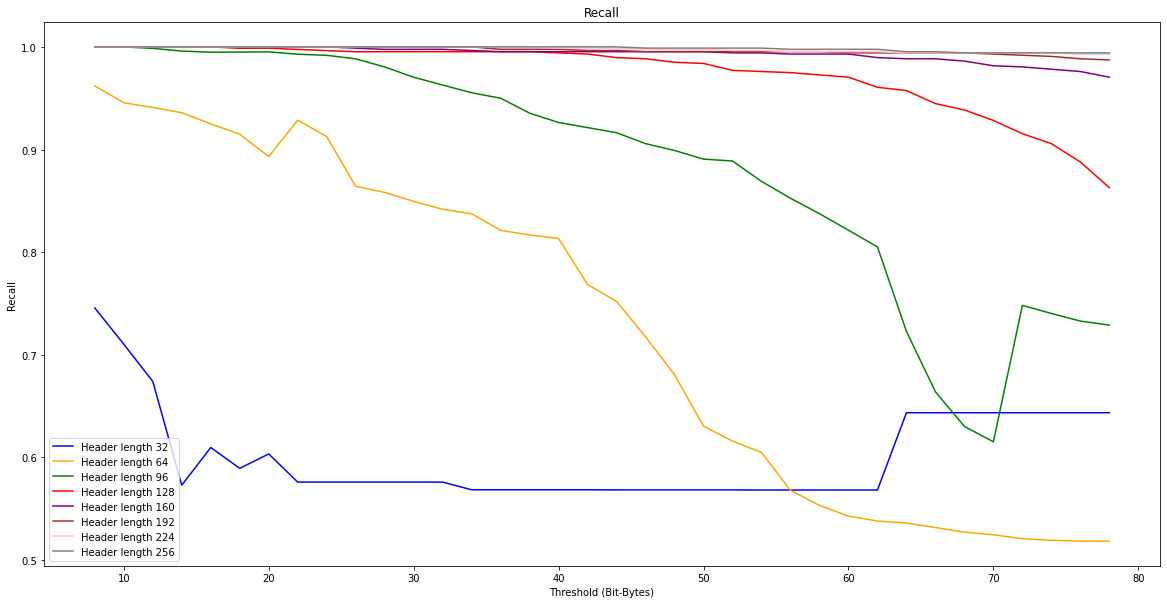

In [19]:
# Recall = TP/TP+FN

# Get for each threshold and header length the recall
hl_thresh= np.zeros([int(offset/8),len(thresholds)])
for i in range(int(offset/8)):
    for j in range(len(thresholds)):
        sumTP=0
        sumFN=0
        for k in range(len(paths)):
            sumTP=sumTP+TP_des[j][k][i]
            sumFN=sumFN+FN_des[j][k][i]
        if ((sumTP+sumFN))>0:
            hl_thresh[i][j] = sumTP/(sumTP+sumFN)

# Plot of the recall obtained using different threshold and different header lengths
plt.figure(figsize=(20,10))
plt.title("Recall")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("Recall")
plt.plot(thresholds, hl_thresh[3], color="blue", label="Header length 32")
plt.plot(thresholds, hl_thresh[7], color="orange", label="Header length 64")
plt.plot(thresholds, hl_thresh[11], color="green", label="Header length 96")
plt.plot(thresholds, hl_thresh[15], color="red", label="Header length 128")
plt.plot(thresholds, hl_thresh[19], color="purple", label="Header length 160")
plt.plot(thresholds, hl_thresh[23], color="brown", label="Header length 192")
plt.plot(thresholds, hl_thresh[27], color="pink", label="Header length 224")
plt.plot(thresholds, hl_thresh[31], color="grey", label="Header length 256")
plt.legend()
plt.show()

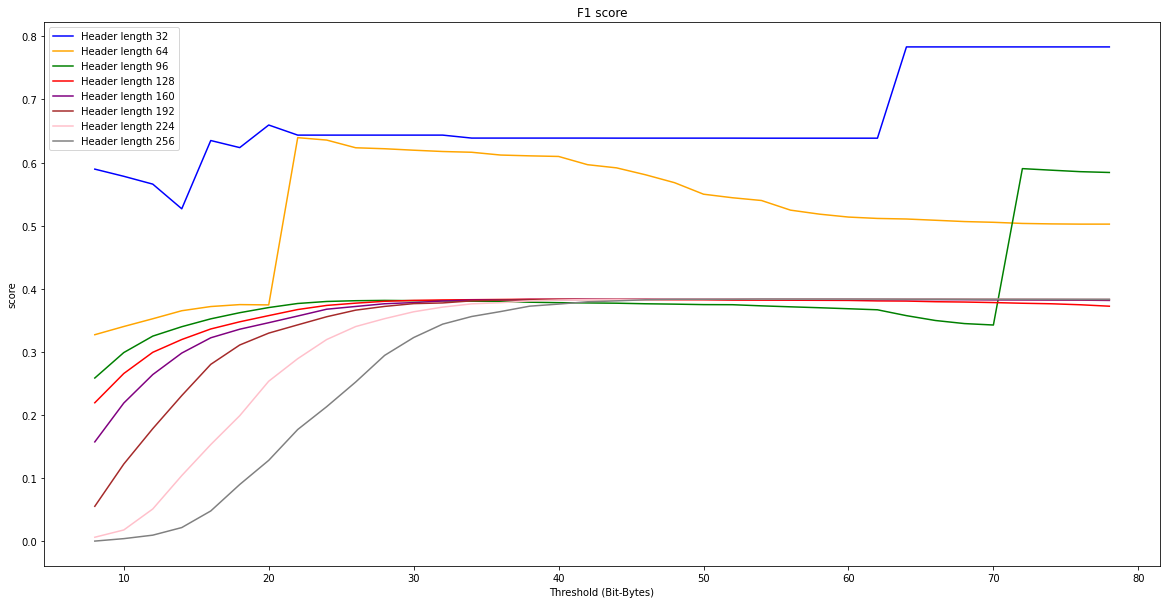

In [20]:
# F1 score = 2*(Recall * Precision) / (Recall + Precision)

# Get for each threshold and header length the f1 score
hl_thresh= np.zeros([int(offset/8),len(thresholds)])
for i in range(int(offset/8)):
    for j in range(len(thresholds)):
        sumTP=0
        sumTN=0
        sumFP=0
        sumFN=0
        for k in range(len(paths)):
            sumTP=sumTP+TP_des[j][k][i]
            sumTN=sumTN+TN_des[j][k][i]
            sumFP=sumFP+FP_des[j][k][i]
            sumFN=sumFN+FN_des[j][k][i]
        if ((sumTP+sumFN)>0) and ((sumTP+sumFP)>0) :
            precision= sumTP/(sumTP+sumFP)
            recall= sumTP/(sumTP+sumFN)
            hl_thresh[i][j] = 2*(recall*precision)/(recall+precision)
            
# Plot of the f1 score obtained using different threshold and different header lengths
plt.figure(figsize=(20,10))
plt.title("F1 score")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("score")
plt.plot(thresholds, hl_thresh[3], color="blue", label="Header length 32")
plt.plot(thresholds, hl_thresh[7], color="orange", label="Header length 64")
plt.plot(thresholds, hl_thresh[11], color="green", label="Header length 96")
plt.plot(thresholds, hl_thresh[15], color="red", label="Header length 128")
plt.plot(thresholds, hl_thresh[19], color="purple", label="Header length 160")
plt.plot(thresholds, hl_thresh[23], color="brown", label="Header length 192")
plt.plot(thresholds, hl_thresh[27], color="pink", label="Header length 224")
plt.plot(thresholds, hl_thresh[31], color="grey", label="Header length 256")
plt.legend()
plt.show()

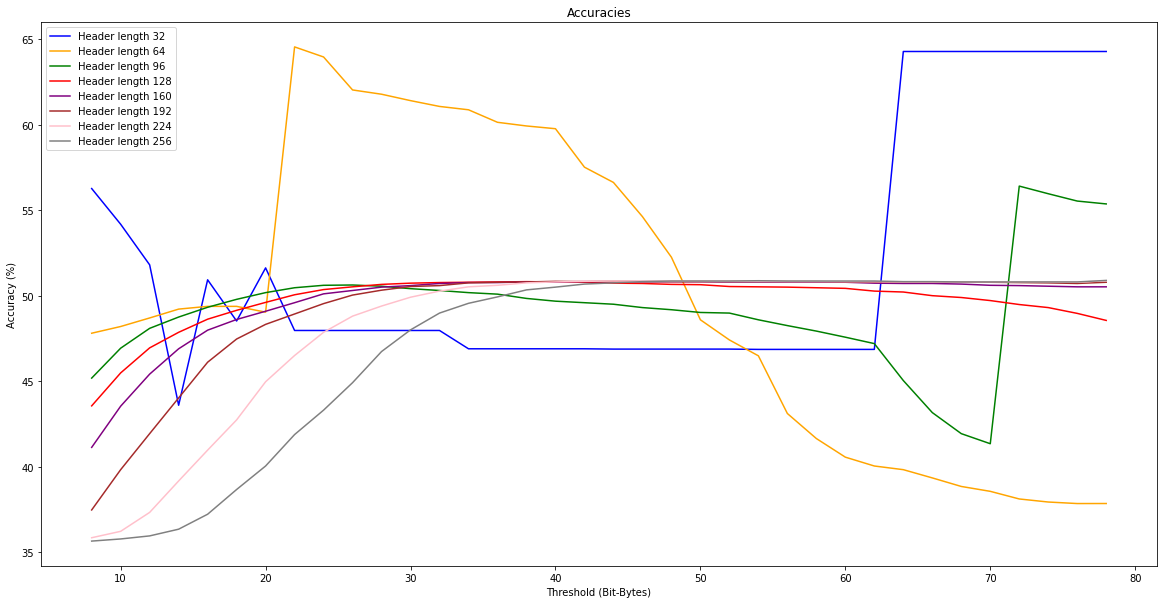

In [21]:
# Accuracy = (TP+TN)/(TP+TN+FP+FN)

# Get for each threshold and header length the total amount of accuracies
hl_thresh = np.divide(np.sum(acc_des, axis=(1)), np.shape(acc_des)[1]).transpose()

# Plot of the accuracies obtained using different threshold and different header lengths
plt.figure(figsize=(20,10))
plt.title("Accuracies")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("Accuracy (%)")
plt.plot(thresholds, hl_thresh[3], color="blue", label="Header length 32")
plt.plot(thresholds, hl_thresh[7], color="orange", label="Header length 64")
plt.plot(thresholds, hl_thresh[11], color="green", label="Header length 96")
plt.plot(thresholds, hl_thresh[15], color="red", label="Header length 128")
plt.plot(thresholds, hl_thresh[19], color="purple", label="Header length 160")
plt.plot(thresholds, hl_thresh[23], color="brown", label="Header length 192")
plt.plot(thresholds, hl_thresh[27], color="pink", label="Header length 224")
plt.plot(thresholds, hl_thresh[31], color="grey", label="Header length 256")
plt.legend()
plt.show()